In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score

In [2]:
df_original = pd.read_csv("sales_train_final.csv")
df_original

,Unnamed: 0,date_block_num_x,item_id,shop_id,month_year_name_sort,item_cnt_month,item_cnt_last_month,item_cnt_last_year,month_year_name,month_of_year,quarter,year_half,year,red_day_not_sun
0,0,0,19,0,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
1,1,0,19,1,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
2,2,0,19,2,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
3,3,0,19,3,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
4,4,0,19,4,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,10913845,33,22167,55,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913846,10913846,33,22167,56,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913847,10913847,33,22167,57,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913848,10913848,33,22167,58,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31


In [3]:
df_draft = df_original.copy()

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'date_block_num_x'}>,
        <Axes: title={'center': 'item_id'}>,
        <Axes: title={'center': 'shop_id'}>],
       [<Axes: title={'center': 'month_year_name_sort'}>,
        <Axes: title={'center': 'item_cnt_month'}>,
        <Axes: title={'center': 'item_cnt_last_month'}>,
        <Axes: title={'center': 'item_cnt_last_year'}>],
       [<Axes: title={'center': 'month_of_year'}>,
        <Axes: title={'center': 'quarter'}>,
        <Axes: title={'center': 'year_half'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'red_day_not_sun'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

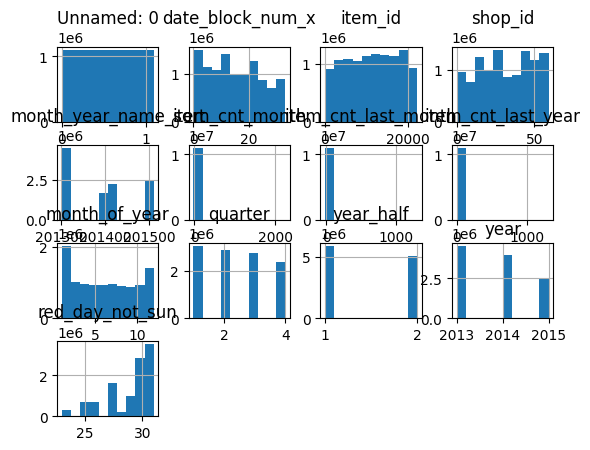

In [4]:
df_draft.hist()

In [5]:
mm_scaler = MinMaxScaler()
df_draft["item_cnt_last_month"] = mm_scaler.fit_transform(df_draft[["item_cnt_last_month"]])
df_draft["item_cnt_last_year"] = mm_scaler.fit_transform(df_draft[["item_cnt_last_year"]])
df_draft["red_day_not_sun"] = mm_scaler.fit_transform(df_draft[["red_day_not_sun"]])

In [6]:
unique_values = df_draft['date_block_num_x'].unique()[-2:]

test = df_draft[df_draft['date_block_num_x'].isin(unique_values)]

train = df_draft[~df_draft['date_block_num_x'].isin(unique_values)]

In [7]:
features = [
    "item_cnt_last_month"
]
y_test = test["item_cnt_month"]
X_test = test[features]

y_train = train["item_cnt_month"]
X_train = train[features]


In [8]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

LinearRegression()

In [9]:
y_pred = model.predict(X_test)

In [13]:
np.sqrt(mean_squared_error(y_true=np.clip(y_test, 0, 20), y_pred=np.clip(y_pred, 0, 20)))

1.0120525315903945